# Week 4 - Function 3 ((18DP, 3D))

# Setup
Let's load all the imports in the top to avoid repeating and simplify the readability of each solution.

In [1]:

import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.svm import SVC, SVR
from scipy.stats.qmc import LatinHypercube
from ipywidgets import interact, FloatSlider

from utils.plotting_utils import (
    plot_bar,
    plot_bar_diff,
    plot_log_transform,
    plot_3D_mean_uncertainty_slice,
    plot_svm_analysis_slice,
    plot_acquisition_comparison_slice
)


# Plan
We now have ((18, 3)) - 18DP & 3D that can be found `./data/week_4/function_3/`.

1. Load data
2. Preprocessing (QuantileTransformer + Log Transform)
3. Build probabilistic Models (GP on QuantileTransformer + GP on log-space)
4. SVM Analysis (Classifier + SVR surrogates on both targets)
5. Acquisition Function (SVM-constrained UCB, 4-surrogate ensemble)

# 1. Load data

In [2]:

X_train_raw = np.load(r"./data/week_4/function_3/inputs.npy")
y_train_raw = np.load(r"./data/week_4/function_3/outputs.npy")

print(f"Shape: X={X_train_raw.shape}, y={y_train_raw.shape}")
print(f"X range: [{X_train_raw.min():.4f}, {X_train_raw.max():.4f}]")
print(f"y range: [{y_train_raw.min():.2e}, {y_train_raw.max():.2e}]")


Shape: X=(18, 3), y=(18,)
X range: [0.0468, 0.9909]
y range: [-3.99e-01, -3.26e-02]


# 2. Preprocessing

The output data contains a significant negative outlier, similar to other functions. `StandardScaler` is ineffective in this scenario as it collapses the variance of the non-outlier points. We will use `QuantileTransformer` to rank the data and spread it uniformly, and also a `log10` transform for positive-only points to model the magnitude differences.

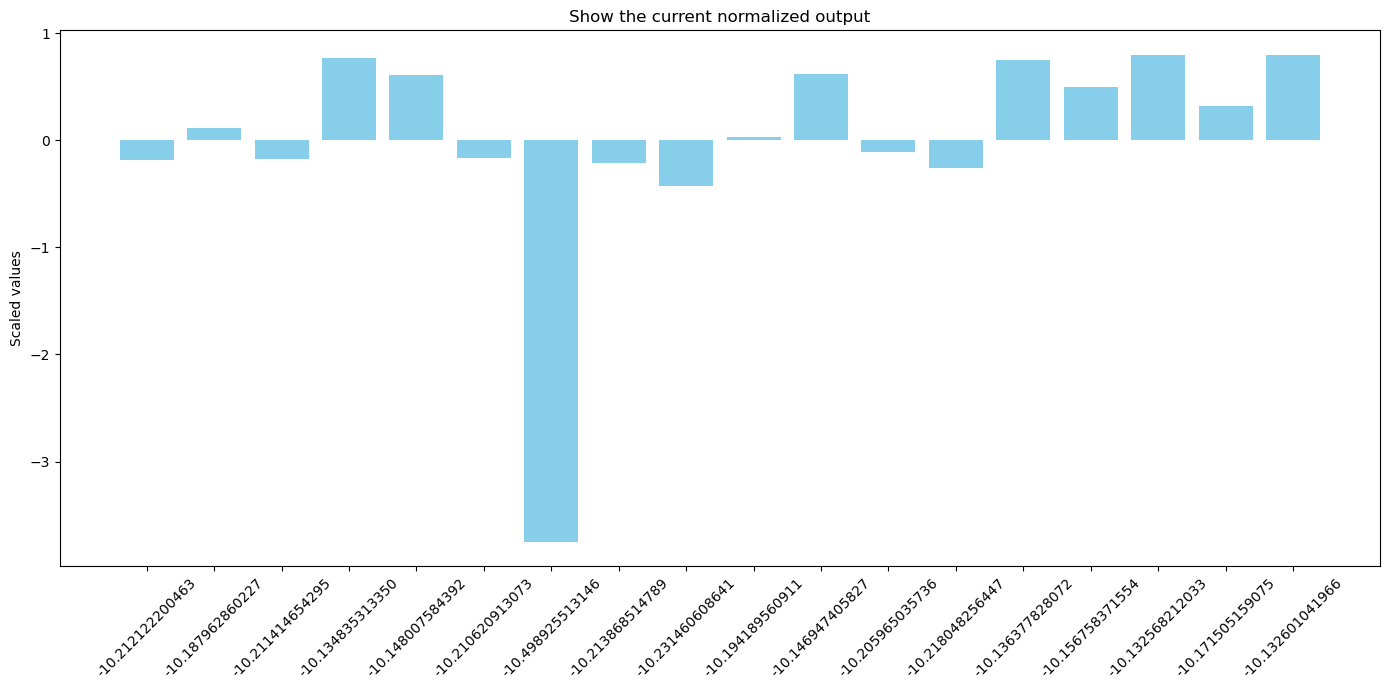

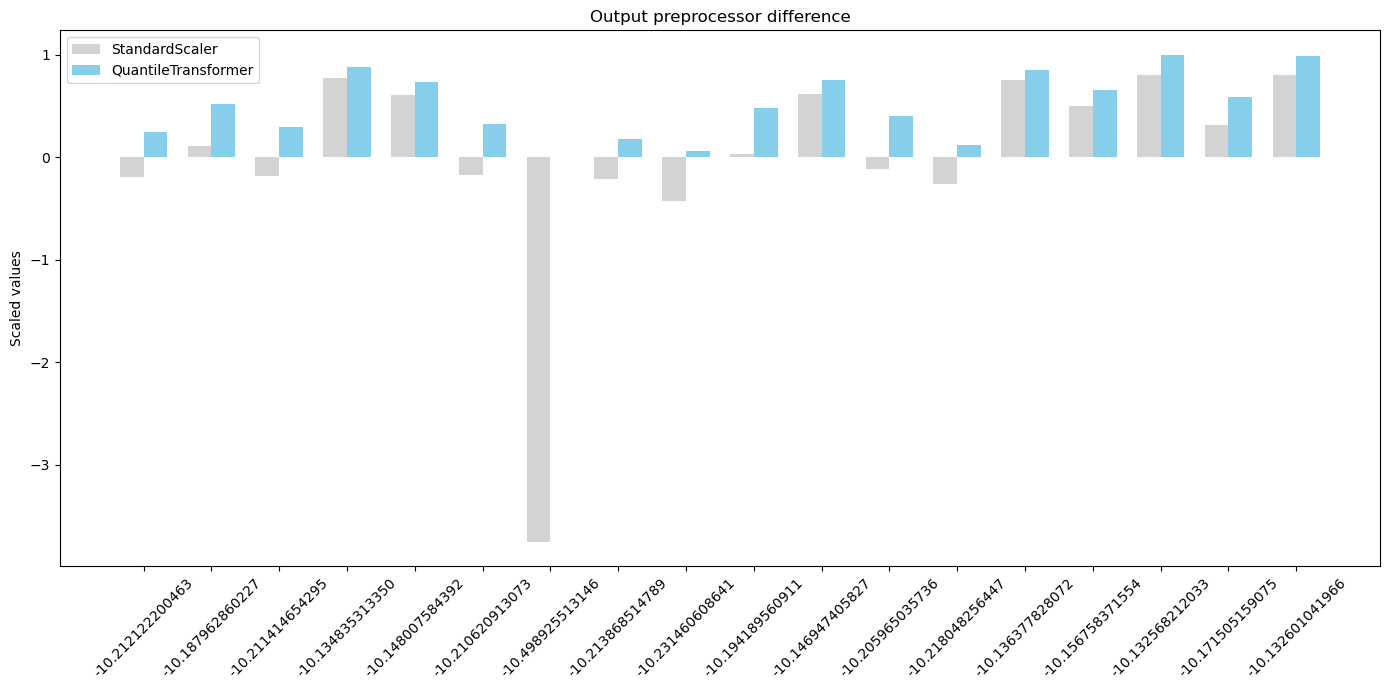

Total points: 18
Range for new normalized output: [0.0, 1.0]
Best point: X=[0.478263 0.705786 0.066089], y=-3.26e-02, QuantileTransformer(y)=1.0


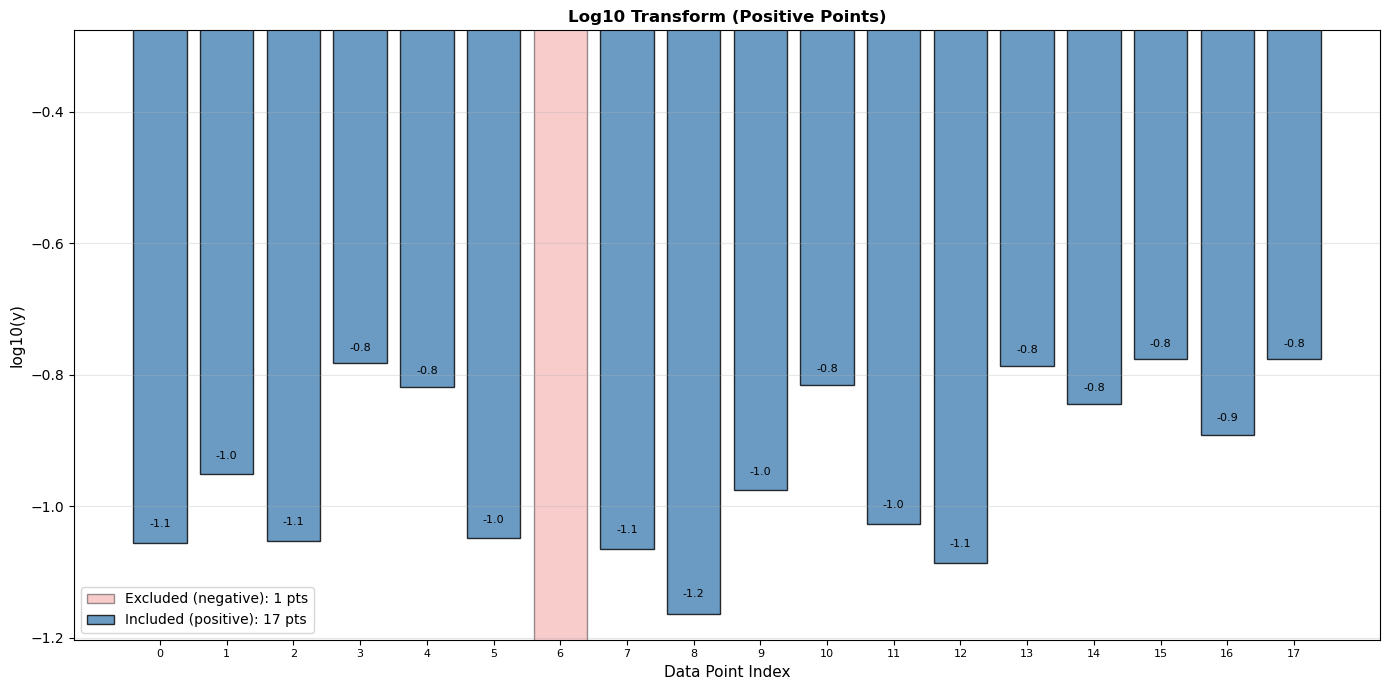

In [3]:
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train_raw)

scaler_ss = StandardScaler()
y_ss = scaler_ss.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

scaler_qt = QuantileTransformer(n_quantiles=len(y_train_raw)-1, output_distribution='uniform')
y_qt = scaler_qt.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

plot_bar(y_train_raw, y_ss, 'Scaled values', 'Show the current normalized output')

plot_bar_diff(y_train_raw, y_ss, y_qt, 'StandardScaler', 'QuantileTransformer', 'Scaled values', 'Output preprocessor difference')

print(f"Total points: {len(X_train)}")
print(f"Range for new normalized output: [{y_qt.min():.1f}, {y_qt.max():.1f}]")
print(f"Best point: X={X_train_raw[np.argmax(y_train_raw)]}, y={y_train_raw.max():.2e}, QuantileTransformer(y)={y_qt.max():.1f}")

# Apply a shift to make values positive for log transformation
log_shift_constant = .2
y_train_raw_shifted = y_train_raw + log_shift_constant

# Create a mask for values that are now positive after the shift
# (This mask will be all True since original y_train_raw are negative and shifted by +1)
pos_mask = y_train_raw_shifted > 0

# Use the original X_train, but masked by the new log-positive mask for the log-space GP
# This effectively makes X_train_pos include all points for the log GP due to the shift.
X_train_pos = X_train[pos_mask]

# Calculate the log-transformed values from the shifted data
y_log_pos = np.log10(y_train_raw_shifted[pos_mask])

# Call the plotting function. Pass the original y_train_raw, but the new y_log_pos and its mask.
# The plot_log_transform function plots excluded points based on original y_raw context.
plot_log_transform(y_train_raw, y_log_pos, pos_mask)

# 3. Build probabilistic Models

We build two GP models with different preprocessing to create a more robust ensemble:
- **gp_qt** (QuantileTransformer, all 18 points): Models the rank-transformed data.
- **gp_log** (log10, positive points): Models the output magnitude in log-space.

In [4]:

# GP on QuantileTransformer output (all points) — ARD kernel
gp_qt = GaussianProcessRegressor(
    kernel=ConstantKernel(0.25, (1e-3, 10)) * Matern(
        length_scale=[0.5, 0.5, 0.5],
        nu=2.5,
        length_scale_bounds=(0.05, 50.0)
    ),
    alpha=0.01,
    normalize_y=True,
    n_restarts_optimizer=30,
    optimizer='fmin_l_bfgs_b'
)

# GP in log-space on positive points only — ARD kernel
gp_log = GaussianProcessRegressor(
    kernel=ConstantKernel(1.0, (1e-3, 1e3)) * Matern(
        length_scale=[0.3, 0.3, 0.3],
        nu=2.5,
        length_scale_bounds=(1e-3, 50.0)
    ),
    alpha=1e-4,
    normalize_y=True,
    n_restarts_optimizer=50
)

gp_qt.fit(X_train, y_qt)
gp_log.fit(X_train_pos, y_log_pos)

print(f"GP(QT) kernel: {gp_qt.kernel_}")
print(f"GP(log) kernel: {gp_log.kernel_}")

# Feature importance from ARD length scales
for name, gp in [('GP(QT)', gp_qt), ('GP(log)', gp_log)]:
    ls = gp.kernel_.k2.length_scale
    imp = 1.0 / ls
    imp_norm = imp / imp.sum() * 100
    print(f"\n{name} length scales: {ls}")
    sorted_dims = np.argsort(ls)
    for i in sorted_dims:
        role = 'IMPORTANT' if ls[i] < 1.0 else ('moderate' if ls[i] < 5.0 else 'noise')
        print(f"  x{i+1}: ls={ls[i]:.4f}, importance={imp_norm[i]:.1f}%, {role}")

# Create prediction grid (kept for interactive visualization)
n_grid = 20
x1_range = np.linspace(0, 1, n_grid)
x2_range = np.linspace(0, 1, n_grid)
x3_range = np.linspace(0, 1, n_grid)
X1_test, X2_test, X3_test = np.meshgrid(x1_range, x2_range, x3_range)
X_grid = np.c_[X1_test.ravel(), X2_test.ravel(), X3_test.ravel()]

# Interactive 2D slice plotting
def plot_gp_slices(x3_slice):
    grid_slice = np.c_[X_grid[:, 0], X_grid[:, 1], np.full_like(X_grid[:, 0], x3_slice)]
    
    mu_gp_qt, sigma_gp_qt = gp_qt.predict(grid_slice, return_std=True)
    mu_gp_log, sigma_gp_log = gp_log.predict(grid_slice, return_std=True)
    
    X_train_neg = X_train[~pos_mask]
    
    plot_3D_mean_uncertainty_slice(
        X_train, X1_test[:,:,0], X2_test[:,:,0], mu_gp_qt.reshape(n_grid, n_grid, n_grid)[:,:, int(x3_slice*(n_grid-1))], sigma_gp_qt.reshape(n_grid, n_grid, n_grid)[:,:, int(x3_slice*(n_grid-1))],
        title_prefix="GP (QT)", x3_slice_val=x3_slice
    )
    plot_3D_mean_uncertainty_slice(
        X_train_pos, X1_test[:,:,0], X2_test[:,:,0], mu_gp_log.reshape(n_grid, n_grid, n_grid)[:,:, int(x3_slice*(n_grid-1))], sigma_gp_log.reshape(n_grid, n_grid, n_grid)[:,:, int(x3_slice*(n_grid-1))],
        X_excluded=X_train_neg, title_prefix="GP (log)", x3_slice_val=x3_slice
    )

interact(plot_gp_slices, x3_slice=FloatSlider(min=0, max=1, step=0.1, value=0.5, description="X3 Slice"))


GP(QT) kernel: 1.08**2 * Matern(length_scale=[1.02, 0.745, 0.102], nu=2.5)
GP(log) kernel: 1.08**2 * Matern(length_scale=[50, 0.833, 0.0738], nu=2.5)

GP(QT) length scales: [1.0243709  0.74538959 0.10155005]
  x3: ls=0.1016, importance=80.9%, IMPORTANT
  x2: ls=0.7454, importance=11.0%, IMPORTANT
  x1: ls=1.0244, importance=8.0%, moderate

GP(log) length scales: [50.          0.83337596  0.07377158]
  x3: ls=0.0738, importance=91.7%, IMPORTANT
  x2: ls=0.8334, importance=8.1%, IMPORTANT
  x1: ls=50.0000, importance=0.1%, noise


/opt/anaconda3/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 50.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


interactive(children=(FloatSlider(value=0.5, description='X3 Slice', max=1.0), Output()), _dom_classes=('widge…

<function __main__.plot_gp_slices(x3_slice)>

# 4. SVM Analysis

To handle the penalty zone (negative outputs) and create a more diverse model ensemble, we use three SVMs:
1. **SVM Classifier**: Learns the boundary between 'promising' (positive output) and 'unpromising' (negative output) regions.
2. **SVR Surrogate (log-space)**: An independent surrogate model trained on the log-transformed positive outputs.
3. **SVR Surrogate (QuantileTransformer)**: A second independent surrogate trained on the quantile-transformed outputs.

In [5]:

# --- 2a. SVM Classifier: promising vs not-promising regions ---
# Label points as "promising" if positive AND log10(y) > -50 (closer to peak)
# Use pre-computed y_log_pos via pos_mask to avoid computing log of negatives
svm_labels = np.zeros(len(y_train_raw), dtype=int)
for i, yi in enumerate(y_log_pos):
    if yi > -50:
        svm_labels[np.where(pos_mask)[0][i]] = 1

svm_clf = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
svm_clf.fit(X_train, svm_labels)

# --- 2b. SVR Surrogate in log-space (positive points only) ---
svr_log = SVR(kernel='rbf', C=100, gamma='scale', epsilon=5.0)
svr_log.fit(X_train_pos, y_log_pos)

# --- 2c. SVR Surrogate on QuantileTransformer output (all points) ---
svr_qt = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svr_qt.fit(X_train, y_qt)

# --- Interactive plotting for SVMs ---
def plot_svm_slices(x3_slice):
    grid_slice = np.c_[X_grid[:, 0], X_grid[:, 1], np.full_like(X_grid[:, 0], x3_slice)]
    
    svm_proba_slice = svm_clf.predict_proba(grid_slice)[:, 1]
    mu_svr_log_slice = svr_log.predict(grid_slice)
    mu_svr_qt_slice = svr_qt.predict(grid_slice)
    
    X_train_neg = X_train[~pos_mask]

    plot_svm_analysis_slice(
        X1_test[:,:,0], X2_test[:,:,0],
        svm_proba_slice.reshape(n_grid, n_grid, n_grid)[:,:, int(x3_slice*(n_grid-1))],
        mu_svr_log_slice.reshape(n_grid, n_grid, n_grid)[:,:, int(x3_slice*(n_grid-1))],
        mu_svr_qt_slice.reshape(n_grid, n_grid, n_grid)[:,:, int(x3_slice*(n_grid-1))],
        X_train, X_train_pos, X_train_neg, svm_labels, x3_slice
    )

interact(plot_svm_slices, x3_slice=FloatSlider(min=0, max=1, step=0.1, value=0.5, description="X3 Slice"))


interactive(children=(FloatSlider(value=0.5, description='X3 Slice', max=1.0), Output()), _dom_classes=('widge…

<function __main__.plot_svm_slices(x3_slice)>

# 5. Acquisition Function (SVM-constrained UCB Ensemble)

We combine the GP predictions into a single acquisition function:
- **UCB**: We use Upper Confidence Bound to balance exploration and exploitation.
- **SVM constraint**: The UCB score is multiplied by the SVM's P(promising) to steer the search away from penalty zones.
- **2-GP ensemble**: We average the normalized, constrained UCB scores from both GPs (gp_qt, gp_log) for a robust recommendation.

**Note:** The SVR surrogates are kept for the SVM analysis (Section 4) as independent surface visualizations, but are excluded from the acquisition ensemble. SVRs lack native uncertainty estimates, and with only 17 points in 3D, synthetic uncertainty proxies (e.g. distance-based) consistently over-explore toward boundaries. The two GPs already provide model diversity through different preprocessing (QuantileTransformer vs log-space).

In [ ]:

def upper_confidence_bound(mu, sigma, kappa=2.0):
    return mu + kappa * sigma

def constrained_ucb(ucb_vals, svm_proba):
    ucb_shifted = ucb_vals - ucb_vals.min() + 1e-6
    return ucb_shifted * svm_proba

def normalize_01(arr):
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-10)

# --- Use LHS candidates instead of coarse grid to avoid boundary bias ---
sampler = LatinHypercube(d=3, seed=42)
X_candidates = sampler.random(n=10_000)

kappa = 5.0

# GP predictions on LHS candidates
mu_gp_qt, sigma_gp_qt = gp_qt.predict(X_candidates, return_std=True)
mu_gp_log, sigma_gp_log = gp_log.predict(X_candidates, return_std=True)

# SVM probability (constraint)
svm_proba = svm_clf.predict_proba(X_candidates)[:, 1]

# UCB scores
ucb_gp_qt = upper_confidence_bound(mu_gp_qt, sigma_gp_qt, kappa=kappa)
ucb_gp_log = upper_confidence_bound(mu_gp_log, sigma_gp_log, kappa=kappa)

# SVM-constrained UCB
ucb_c_gp_qt = constrained_ucb(ucb_gp_qt, svm_proba)
ucb_c_gp_log = constrained_ucb(ucb_gp_log, svm_proba)

# Ensemble: average the 2 normalized constrained GP UCBs
ensemble_ucb = (normalize_01(ucb_c_gp_qt) + normalize_01(ucb_c_gp_log)) / 2.0

best_ensemble_idx = np.argmax(ensemble_ucb)
x_next_norm = X_candidates[best_ensemble_idx]
x_next_orig = scaler_X.inverse_transform([x_next_norm])[0]

# Find best point per surrogate for reporting
surrogates = {
    'GP (y_qt)': ucb_c_gp_qt,
    'GP (y_log_pos)': ucb_c_gp_log,
}
best_points = {}
for name, ucb_vals in surrogates.items():
    idx = np.argmax(ucb_vals)
    best_points[name] = {
        'idx': idx,
        'norm': X_candidates[idx],
        'orig': scaler_X.inverse_transform([X_candidates[idx]])[0],
        'svm_p': svm_proba[idx],
    }

# --- Interactive Plotting Slices (using grid for visualization) ---
# Recompute on grid for visualization only
svm_proba_grid = svm_clf.predict_proba(X_grid)[:, 1]
mu_qt_grid, sigma_qt_grid = gp_qt.predict(X_grid, return_std=True)
mu_log_grid, sigma_log_grid = gp_log.predict(X_grid, return_std=True)
ucb_qt_grid = constrained_ucb(upper_confidence_bound(mu_qt_grid, sigma_qt_grid, kappa), svm_proba_grid)
ucb_log_grid = constrained_ucb(upper_confidence_bound(mu_log_grid, sigma_log_grid, kappa), svm_proba_grid)
ensemble_grid = (normalize_01(ucb_qt_grid) + normalize_01(ucb_log_grid)) / 2.0

surrogates_grid = {
    'GP (y_qt)': ucb_qt_grid,
    'GP (y_log_pos)': ucb_log_grid,
}

def plot_acquisition_slices(x3_slice):
    _slice_idx = int(x3_slice * (n_grid - 1))
    
    surrogate_slices = {name: val.reshape(n_grid, n_grid, n_grid)[:, :, _slice_idx] for name, val in surrogates_grid.items()}
    svm_proba_slice = svm_proba_grid.reshape(n_grid, n_grid, n_grid)[:, :, _slice_idx]
    ensemble_ucb_slice = ensemble_grid.reshape(n_grid, n_grid, n_grid)[:, :, _slice_idx]
    
    X_train_neg = X_train[~pos_mask]

    plot_acquisition_comparison_slice(
        X1_test[:,:,0], X2_test[:,:,0],
        surrogate_slices, svm_proba_slice, ensemble_ucb_slice,
        X_train_pos, X_train_neg,
        x3_slice_val=x3_slice
    )

interact(plot_acquisition_slices, x3_slice=FloatSlider(min=0, max=1, step=0.1, value=x_next_norm[2], description="X3 Slice"))

# --- Summary ---
print(f"{'='*80}")
print(f"RECOMMENDED NEXT POINT (Ensemble of 2 GPs, 10K LHS candidates)")
print(f"{'='*80}")
print(f"  Input (original space): {np.array_str(x_next_orig, precision=6)}")
print(f"  SVM P(promising):       {svm_proba[best_ensemble_idx]:.3f}")

print(f"\nIndividual surrogate suggestions:")
for name, bp in best_points.items():
    print(f"    {name:20s}: {np.array_str(bp['orig'], precision=6)}, SVM P={bp['svm_p']:.3f})")

print(f"\nSanity check - is this a corner?")
for i in range(3):
    at_boundary = x_next_norm[i] < 0.02 or x_next_norm[i] > 0.98
    print(f"  x{i+1} = {x_next_norm[i]:.4f} {'<-- BOUNDARY!' if at_boundary else ''}")

print(f"\nCurrent best: {X_train_raw[np.argmax(y_train_raw)]} (y = {y_train_raw.max()})")


interactive(children=(FloatSlider(value=0.6538764015053334, description='X3 Slice', max=1.0), Output()), _dom_…

RECOMMENDED NEXT POINT (Ensemble of 2 GPs, 10K LHS candidates)
  Input (original space): [0.159951 0.921039 0.670789]
  SVM P(promising):       0.917

Individual surrogate suggestions:
    GP (y_qt)           : [0.228575 0.223939 0.069841], SVM P=0.912)
    GP (y_log_pos)      : [0.348058 0.222831 0.632057], SVM P=0.910)

Sanity check - is this a corner?
  x1 = 0.1231 
  x2 = 0.9718 
  x3 = 0.6539 

Current best: [0.478263 0.705786 0.066089] (y = -0.032568212033085034)
